## AR, MA, ARIMA

Dans ce notebook, nous allons présenter des modèles très classiques, utilisés couramment pour réaliser de la prédiction sur des séries temporelles. 

Ce notebook a été construit à partir de la source suivante : [*Practical Time Series Analysis, Prediction with Statistics & Machine Learning*, Aileen Nielsen, 2020](https://www.oreilly.com/library/view/practical-time-series/9781492041641/).

Il sont basés sur de la [regression linéaire](https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire), mais prennent en compte en plus la corrélation présente entre les points. En effet, les méthode de régression linéaire assument que les données sont indépendantes et identicallement distribuées, ce qui n'est pas le cas pour des séries temporelles. 

**Attention, pour rappel : ces modèles sont censés fonctionner sur des séries temporelles stationnaires.**

Notez aussi que généralement, ces modèles sont utilisés pour réaliser des prédictions à court terme. Nous pourrions donc les utiliser pour prédire les prix à 2-3 jours dans le futur.

Avant de commencer la présentation de ces modèles, nous allons charger nos données.



### Les données

Dans ce notebook, nous allons toujours utiliser nos données de valeurs mobilières, mais nous allons appliquer des techniques vues précédemment pour tenter de rendre la série stationnaire, via un passage en différentiel.

['data\\Coindex\\coin_Cardano.csv', 'data\\Coindex\\coin_Bitcoin.csv', 'data\\Coindex\\coin_Ethereum.csv']
Coin loaded:  data\Coindex\coin_Cardano.csv Cardano


**Dtypes**:


Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap    float64
dtype: object


**From**:


2017-10-01 00:00:00  to  2022-08-17 00:00:00
Coin loaded:  data\Coindex\coin_Bitcoin.csv Bitcoin


**Dtypes**:


Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap    float64
dtype: object


**From**:


2010-07-16 00:00:00  to  2022-08-17 00:00:00
Coin loaded:  data\Coindex\coin_Ethereum.csv Ethereum


**Dtypes**:


Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap    float64
dtype: object


**From**:


2015-08-07 00:00:00  to  2022-08-17 00:00:00


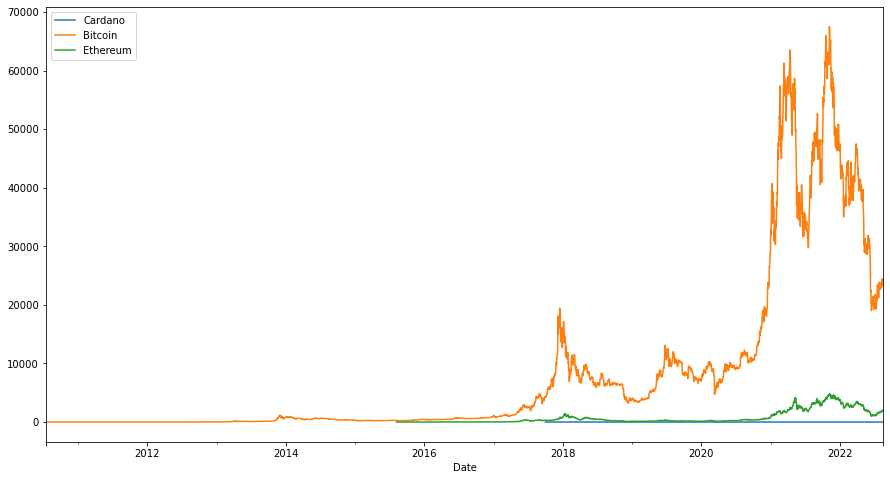

In [28]:
%run -i "05 - LoadData.ipynb"
plt.rcParams['figure.figsize'] = [15, 8]


Application du traitement pour la stationnarité :

In [29]:
dataDiff = data.Close.diff()

dataDiff = dataDiff.dropna()

print(type(dataDiff))
dataDiff.head()

<class 'pandas.core.series.Series'>


Date
2017-10-02   -0.004982
2017-10-03    0.001146
2017-10-04   -0.000461
2017-10-05   -0.003031
2017-10-06    0.002299
Name: Close, dtype: float64

### Modèle Autoregressive (AR)

Le modèle `autoregressive` (AR) se base sur l'intuition que les données futures dépendent des valeurs passées. Une valeur à l'instant $t$ est ainsi obtenu via une fonction prenant en paramètre des valeurs passées. 

Voici la fonction utilisée, si l'on utilise un modèle AR(1), où l'on se base sur seulement une valeur précédente $t-1$ pour obtenir la valeur à l'instant $t$ :
$$y_t = b_0 + b_1 \cdot y_{t-1} + e_t$$

où $b_0$ est une constante, $b_1$ est une constante et $e_t$ une erreur, ayant une variance et une moyenne constante.

Pour un modèle AR(p), on obtient :
$$y_t = b_0 + b_1 \cdot y_{t-1} + b_2 \cdot y_{t-2} + \dots + b_p \cdot y_{t-p} + e_t$$

Le principal paramètre à fournir à ce modèle est $p$. Pour le déterminer, une méthode graphique est proposée, basée sur les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF), voir ci-dessous.

Nous pouvons maintenant tester ce modèle, en apprenant à partir de nos données, et en demandant une prédiction à $n$ jours. Deux implémentations sont disponibles pour ce modèle, `AutoReg` et un modèle générique `ARIMA` généralisant ce type de modèle. Nous utiliserons ce dernier dans la suite des exemples, puisqu'il englobe tous les modèles vus ici. 



c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


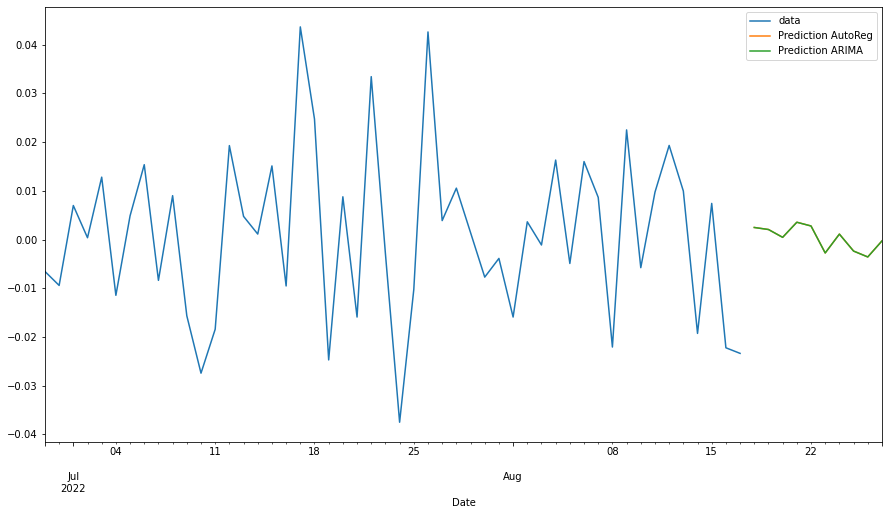

In [30]:

n = 10 # nombre de valeurs prédites
p = 10 # nombre de termes du passé utilisés pour la prédiction

model = AutoReg(dataDiff, lags=p)
resultsAr = model.fit()
dataPredictionAR = resultsAr.forecast(n)

model = ARIMA(dataDiff, order=(p, 0, 0))
resultsAr = model.fit()
dataPrediction = resultsAr.forecast(n)

ax = dataDiff.iloc[-50:].plot() # sélection des 50 dernières valeurs de la série
dataPredictionAR.plot(ax=ax)
dataPrediction.plot(ax=ax)
ax.legend(["data", "Prediction AutoReg", "Prediction ARIMA"])

Notez que les deux implémentations utilisées proposent bien la même prédiction. 

### Questions :
1. faire varier le paramètre p (nommé `lags`) et afficher les prédictions
2. faire varier le paramètre n (le nombre de prédiction) et afficher les prédictions

Vous devriez noter que plus $p$ est petit, plus on converge rapidement vers une valeur constante pour la prédiction.

### MA

Le modèle `moving average` se base sur la fonction suivante :

$$yt = \mu + e_t + \theta_1 \cdot e_{t-1} + \theta_2 \cdot e_{t-2}... + \theta_q \cdot e_{t-q}$$

Le modèle se base donc sur une moyenne constante $\mu$ et les erreurs des termes précédents $e_t$ : les paramètres à apprendre sont les $\theta$ et le paramètre à fournir est le nombre d'instant $t$ dans le passé à prendre en compte.

Nous utilisons encore ici l'implémentation généralisant les modèles autoregressif, `statsmodels.tsa.arima.model.ARIMA`. Ce modèle permet de faire de l'AR ou bien du MA, en configurant le paramètre `order` : `The (p,d,q) order of the model for the autoregressive, differences, and moving average components`. Le paramètre `p` est pour le modèle AR et `q` est pour le modèle MA. En indiquant `order = (0, 0, 10)`, vous n'utilisez donc que le modèle MA.

c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


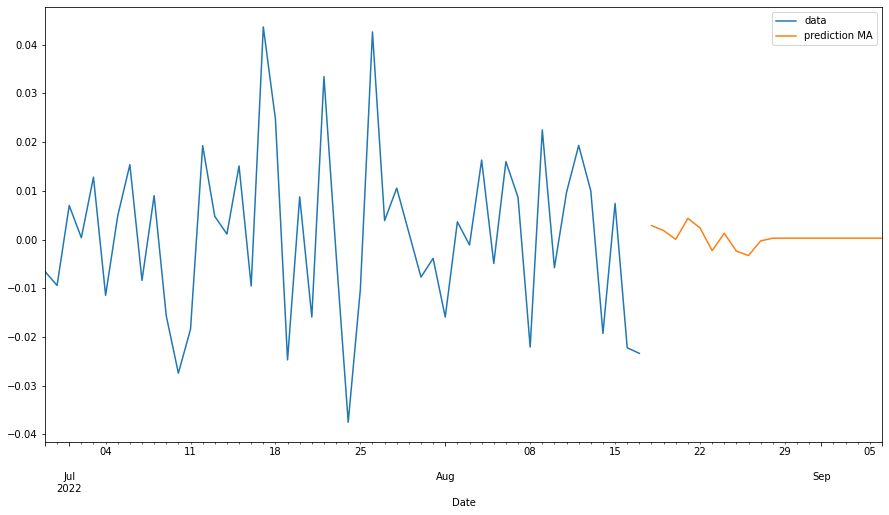

In [31]:
p =0
q = 10
n = 20

model = ARIMA(dataDiff, order=(p, 0, q))

resultsAr = model.fit()

dataPrediction = resultsAr.forecast(n)

ax = dataDiff.iloc[-50:].plot()
dataPrediction.plot(ax=ax)
ax.legend(["data", "prediction MA"])

### Autoregressive Integrated Moving Average Model

Nous pouvons maintenant voir le modèle ARIMA, dont on a déjà utilisé l'implémentation. Ce modèle combine les modèles AR et MA, en prenant comme hypothèse qu'une série temporelle peut combiner le comportement des 2 modèles précédents. 

En plus de combiner ces deux comportements (qui nous aurait seulement emmener vers le modèle ARMA), ce modèle utilise de la différentiation, une manière de supprimer la tendance, et rendant la série stationnaire. Nous avons déjà vu que l'on pouvait rendre une série temporelle en la remplaçant par la différence entre les terme deux à deux. 

Le terme `integrated` du modèle introduit donc un nouveau paramètre, indiquant combien de fois la série doit être différenciée pour produire de la stationnarité. nous avons ainsi maintenant trois paramètres à fournir :
- `p` : le nombre de terme de la série à prendre en compte (modèle AR)
- `d` : le nombre de différentiation (modèle I)
- `q` : le nombre d'erreur à prendre en compte (modèle MA)

c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<AxesSubplot:xlabel='Date'>

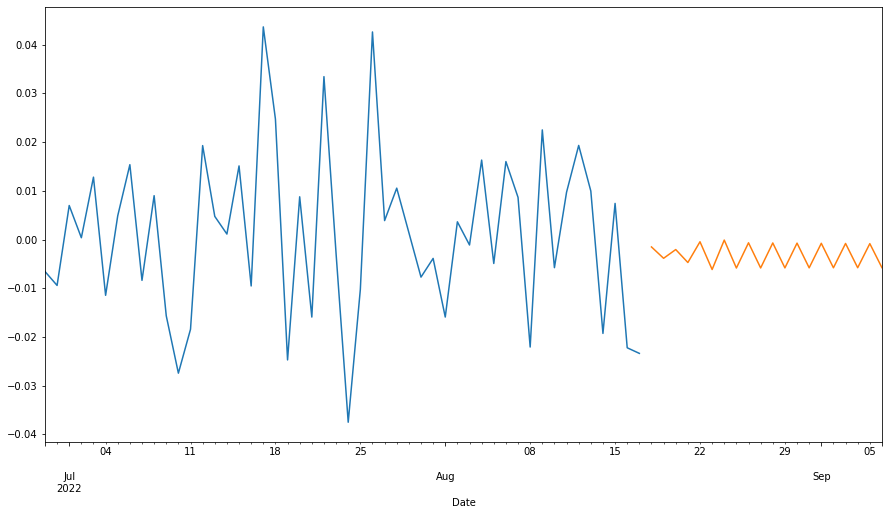

In [32]:
p =1
d = 2
q = 10

n = 20

model = ARIMA(dataDiff, order=(p, d, q))
resultsAr = model.fit()

dataPrediction = resultsAr.forecast(n)

ax = dataDiff.iloc[-50:].plot()
dataPrediction.plot(ax=ax)

Quelques exemples pratiques pour régler les paramètres `(p, d, q)`:
- ARIMA(0,0,0) est un modèle de bruit blanc (données aléatoires)
- ARIMA(0, 1, 0) est une marche aléatoire ($y_t = y_{t-1} + \textrm{bruit blanc}$)
- ARIMA(0, 1, 1) est un `exponential smoothing model`

En pratique, ces paramètres doivent être le plus petit possible. Ainsi, il est généralement conseillé de garder $d \leq 2$ et $(p,q) \leq5$. 

Il nous reste maintenant à voir comment déterminer le bon modèle à utiliser (ce qui revient à déterminer les paramètres $p$ et $q$).


### Autocorrélation & autocorrélation partielle

L'analyse de l'autocorrélation d'une série permet de détecter les patterns de cette série. En pratique, on l'utilise pour déterminer les paramètres des modèles présentés dans ce notebook. 

Voici l'intuition derrière l'autocorrélation : c'est la corrélation d'une série temporelle avec une version d'elle même décalée vers la gauche. La corrélation étant l'explication d'une variable par une autre, on tente de trouver quelles sont les valeurs passées expliquant celles futures. Il faut donc tester plusieurs décalages.

Par exemple, si l'on prend une série de température journalière sur un an sur Nantes, vous trouverez possiblement que la température du 15 mai de chaque année vous donne une information sur la température du 15 août de chaque année (une haute température en mai étant suivi d'une haute temérature en août).

L'autocorrélation est ainsi testée sur plusieurs décalages, via un paramètre, fixant le nombre maximum de décalage. 

Par exemple, le premier décalage testé est toujours de $0$ : on obtient ainsi une corrélation de 1, indiquant que la version décalée explique parfaitement la série (pour rappel, la corrélation varie entre 1 et -1, les extrêmes indiquant une forte corrélation).

Par exemple, du bruit blanc (aucun pattern dans ces données) aura approximativement une valeur de 0 sur tous les lags autre que 0.

L'autocorrélation partielle est plus compliquée à expliquer : c'est la corrélation partielle avec elle même pour un lag donné, connaissant toutes les informations entre les deux points. Vous n'avez pas compris j'imagine...nous allons voir un exemple, ce sera plus clair. Mais voici comment je le résume de mon côté : Le PACF va résumer les informations fournies par l'ACF en enlevant les corrélations redondantes. 

Nous allons voir un exemple sur la fonction $sin(x)$, sur laquelle nous devrions obtenir de l'autocorrélation. Nous définissons et utiliserons par la suite la fonction `plotAcfPacf` affichant directement l'autocorrélation et l'autocorrélation partielle. 

In [33]:

def plotAcfPacf(serie, lag=20):

    lagAcf = acf(serie, nlags=lag, fft=False)
    lagPacf = pacf(serie, nlags=lag, method="ols")

    ax = plt.subplot(121)
    plt.plot(lagAcf)
    plt.axhline(y=0, linestyle="--", color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(serie)), linestyle="--", color='gray')
    plt.axhline(y=1.96/np.sqrt(len(serie)), linestyle="--", color='gray')
    plt.title("Autocorrelation function")

    ax = plt.subplot(122)
    # plot_pacf(serie, lags=lag, ax=ax)
    plt.plot(lagPacf)
    plt.axhline(y=0, linestyle="--", color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(serie)), linestyle="--", color='gray')
    plt.axhline(y=1.96/np.sqrt(len(serie)), linestyle="--", color='gray')
    plt.title("Partial autocorrelation function")
    plt.tight_layout()
    

Voici les données que l'on utilise pour présenter l'ACF et PACF :

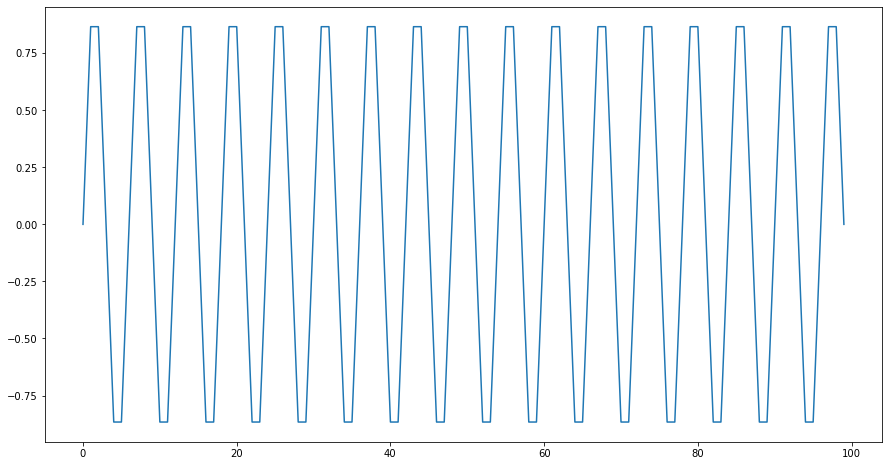

In [34]:
s = [math.sin(x * math.pi/3) for x in range(0,100) ]

plt.plot(s)

Et l'ACF et le PACF sur ces données :

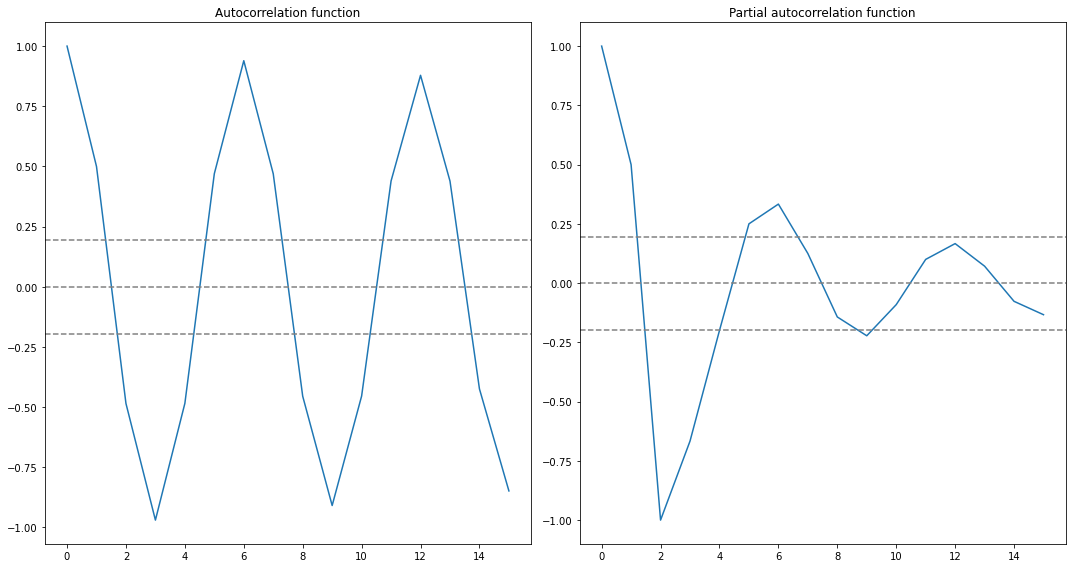

In [35]:
plotAcfPacf(s, lag=15)

Les axes en pointillés nous indiquent si l'autocorrélation est réellement significative. Il faut donc se concentrer sur les valeurs sortant de ces pointillées.

Voici nos commentaires sur l'ACF :
- nous pouvons noter que le lag maximum testé est 15. 
- l'ACF fait apparaitre qu'un lag de 3, 6, 9, ...explique la données courante parfaitement. 
- les lags de 1, 2, 4, 6, 8, ... ont aussi une corrélation significative (de +0.5 ou -0.5)

Nos commentaires sur le PACF : 
- nous pouvons noté que le lag maximum utilisé est 15 (la fonction prend un seul paramètre pour le lag, appliqué à l'ACF et au PACF, donc tout est normal). 
- il est plus concis, et nous montre seulement une auto-corrélation significative pour un lag de 1, 2 et 3, ce qu'on avait déjà trouvé pour l'ACF. L'auto-corrélation est appuyée sur le 2 puisque nous avions une auto-corrélation sur les 2, 4, 6, 8, ....multiple de 2.

Ces deux graphiques vont être utilisés pour déterminer quels modèles utilisés parmi les précédents, en utilisant le tableau suivant :

| Courbe | AR(p) | MA(q) | ARMA(p,q)|
| --- | --- | --- | --- |
| ACF | coupure douce | coupure brutale après `q` | pas de coupure abrupte |
| PACF | coupure brutale après `p` | coupure douce | pas de coupure abrupte |

A partir de ce tableau, vous pouvez tenter de déterminer quel modèle utilisé, avec quel paramètre pour `p` et `q`. Les valeurs de `p` et `q` étant à prendre parmi les valeurs détectées sur les figures ACF et PACF (2, 3 pour `p` et 1, 2 pour `q`).

Alors ? Heureux ? cette méthde vous semble pratique ? il est quand même nécessaire de tatonner, non ?

Une autre solution, qui semble plus simple, est d'utiliser une fonction vous retournant les paramètres `p` et `q`. Ci-dessous, un exemple pour nos données sinus :

In [36]:
dictResult = arma_order_select_ic(s)


print("(p, q) = ",dictResult["bic_min_order"])

c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\2022-Anaconda3\envs\te

(p, q) =  (3, 1)


c:\2022-Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Attention, les deux méthodes précédentes sont à utiliser conjointement. Même si la deuxième semble plus automatique, un industriel aura toujours besoin de visualiser les données ACF et PACF. Chaque jeu de données est différent et nécessite une exploration visuelle et non visuelle. Et chaque outil proposé fonctionne dans un type de contexte.

### Questions :
1. tester les modèles AR, MA, ARMA, ARIMA sur les données sinus
2. faire de même sur les données de valeurs mobilières
3. jouer avec les paramètres des ces modèles et afficher les prédictions obtenues